In [4]:
!pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools numpy;

^C


In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_labels_paper import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras
from keras import backend as K
import random

In [2]:
resnet50 = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))
resnet50.summary()
resnet50.trainable = False

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [3]:
#LAMBDA FUNCTIONS CANNOT BE LOADED!!
def euclidean_distance(vectors):
    (features_A, features_B) = vectors
    sum_squared = K.sum(K.square(features_A - features_B), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))


class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [8]:
input_a = Input(shape=(224,224,3))
input_b = Input(shape=(224,224,3))

features_a = resnet50(input_a)
features_b = resnet50(input_b)

#distance = Lambda(euclidean_distance)([features_a, features_b])
siamese = L1Dist()
distance = siamese(features_a, features_b)
distance = MaxPool2D(4)(distance)
distance = Flatten()(distance)
distance = Dense(2048, activation="relu")(distance)
distance = Dense(2048, activation="relu")(distance)
output = Dense(1, activation="sigmoid")(distance)
siamese_model = Model(inputs=[input_a, input_b], outputs=output)

siamese_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_10[0][0]',               
                                                                  'input_11[0][0]']         

In [9]:
available_files = {}
for d in os.listdir("data/coco_onehot_data"):
    files = os.listdir(f"data/coco_onehot_data/{d}")
    if len(files) > 0:
        available_files[d] = files

print(len(available_files))

80


In [90]:
def get_training_data(epoch_size=1024):
    X_a = []
    X_b = []
    Y = []
    available_classes = list(available_files.keys())

    for i in range(int(epoch_size/2)):

        c = random.choice(available_classes)
        n = random.choice([d for d in available_classes if d is not c])
        anchor = random.choice(available_files[c])
        positive = random.choice(available_files[c])
        negative = random.choice(available_files[n])

        X_a.append(f"data/coco_onehot_data/{c}/{anchor}")
        X_a.append(f"data/coco_onehot_data/{c}/{anchor}")
        X_b.append(f"data/coco_onehot_data/{c}/{positive}")
        X_b.append(f"data/coco_onehot_data/{n}/{negative}")
        Y.append(1)
        Y.append(0)

    return (X_a, X_b, Y)

def get_training_dataset(epoch_size=1024):
    data = get_training_data(epoch_size)
    a = tf.data.Dataset.from_tensor_slices(data[0])
    b = tf.data.Dataset.from_tensor_slices(data[1])
    y = tf.data.Dataset.from_tensor_slices(data[2])
    final_data = tf.data.Dataset.zip((a,b,y))
    processed_data = final_data.map(preprocess_twins)
    return processed_data


In [73]:
dasd = get_training_data()
# random.choice(os.listdir("data/coco_onehot_data/airplane"))
print(len(dasd[0]))

1024


In [91]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)
siamese_model.compile(loss=binary_cross_loss, optimizer=opt, metrics=METRICS)

def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img/255.0
    return img

def preprocess_twins(anchor, validation, label):
    return ((load_images(anchor), load_images(validation)), label)

In [93]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/siamese

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/siamese/{0}'.format(current_time)
weight_dir = 'weights/siamese/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [94]:
for e in range(1):
    train_data = get_training_dataset(2**17)
    train_data = train_data.batch(32)
    train_data = train_data.prefetch(8)

    val_data = get_training_dataset(4096)
    val_data = val_data.batch(32)
    val_data = val_data.prefetch(8)

    #print(len(data[2]))
    loss = siamese_model.fit(train_data, batch_size=32, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])
    print(loss)

C:\PYTHON\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
4096/4096 [==============================] - 695s 168ms/step - loss: 0.6773 - tp: 38175.0000 - fp: 29159.0000 - tn: 36377.0000 - fn: 27361.0000 - accuracy: 0.5688 - precision: 0.5669 - recall: 0.5825 - auc: 0.5980 - prc: 0.5899 - val_loss: 0.6771 - val_tp: 1151.0000 - val_fp: 893.0000 - val_tn: 1155.0000 - val_fn: 897.0000 - val_accuracy: 0.5630 - val_precision: 0.5631 - val_recall: 0.5620 - val_auc: 0.5941 - val_prc: 0.5891
Epoch 2/20
4096/4096 [==============================] - 691s 169ms/step - loss: 0.6709 - tp: 38465.0000 - fp: 28354.0000 - tn: 37182.0000 - fn: 27071.0000 - accuracy: 0.5771 - precision: 0.5757 - recall: 0.5869 - auc: 0.6121 - prc: 0.6066 - val_loss: 0.6768 - val_tp: 1294.0000 - val_fp: 1001.0000 - val_tn: 1047.0000 - val_fn: 754.0000 - val_accuracy: 0.5715 - val_precision: 0.5638 - val_recall: 0.6318 - val_auc: 0.5971 - val_prc: 0.5906
Epoch 3/20
4096/4096 [==============================] - 677s 165ms/step - loss: 0.6654 - tp: 39233.0000 - fp: 27867.000

In [14]:
#siamese_model.save_weights(os.path.join("weights/siamese_pretrained", "model"))
siamese_model.save(os.path.join("weights/siamese_pretrained", "siamesev2"),)

INFO:tensorflow:Assets written to: weights/siamese_pretrained\siamesev2\assets


C:\PYTHON\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\PYTHON\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


tf.Tensor([1 0], shape=(2,), dtype=int32)


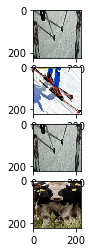

In [87]:
data = get_training_data(2)
a = tf.data.Dataset.from_tensor_slices(data[0])
b = tf.data.Dataset.from_tensor_slices(data[1])
y = tf.data.Dataset.from_tensor_slices(data[2])
final_data = tf.data.Dataset.zip((a,b,y))
processed_data = final_data.map(preprocess_twins)
processed_data = processed_data.batch(2)
processed_data = processed_data.prefetch(2)

img_batch = next(iter(processed_data))

#plt.pyplot.imshow(img_batch[0][0][0])
fig, axs = plt.pyplot.subplots(4,1)
axs[0].imshow(img_batch[0][0][0])
axs[1].imshow(img_batch[0][1][0])

axs[2].imshow(img_batch[0][0][1])
axs[3].imshow(img_batch[0][1][1])
print(img_batch[1])

In [88]:
siamese_model.predict(img_batch[0])

array([[0.85361505],
       [0.39743423]], dtype=float32)